# Training and evaluation notebook for InceptionV3 based Brevis Model.
<HR>
Models are trained on the CIFAR10 dataset, and uses CIFAR100 as an OOD dataset. <br>
    2 models are trained, one with branches using BrevisEnergy Loss and one using Cross entropy for all exits. <br>
    
    


In [5]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
import tensorflow_probability as tfp
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

### load datasets
Inception is initially trained using 224x224x3 image sizes, and because of its convolution process it can't accept CIFAR10 images at their default resolution, so we have scaled the images up to the default size for inception.
<hr>

In [6]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [7]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(224,224),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


## Initialize functions for building the loss functions 
<hr>

In [8]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)


In [9]:
def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl

def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)

def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost

In [10]:
from scipy.special import logsumexp

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        annealing_coef =  lambda_callback.lambda_t
        annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(p,alpha)
        return (A + B) + C
    return custom_loss_function


def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        # evidence = tf.exp(logits)
        evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    return  brevisEnergy


## Build the Model
<hr>

In [17]:
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
     weights='imagenet',include_top=False)


x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=x)


model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

# model.summary()
# train_ds, test_ds, validation_ds = prepareDataset(32)

EPOCHS = 1
for i in range(EPOCHS):
    history = model.fit(train_ds, epochs=EPOCHS, validation_data = validation_ds, batch_size=32)
    loss, accuracy = model.evaluate(test_ds, batch_size=32)
    model.save("inception_finetuned.hdf5")

313/313 [==============================] - 17s 53ms/step - loss: 0.1892 - accuracy: 0.9394


In [38]:
# ### from scratch model

import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
# model.save('./models/cifaroutlier_EDL_adam.hdf5')
# loss = kl_loss(lambda_callback)
# loss = brevisEnergy(lambda_callback)
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# _base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(224, 224, 3),
#      weights='imagenet',include_top=False)

# x = _base_model.output
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1024, activation="relu")(x)
# x = tf.keras.layers.Dense(512, activation="relu")(x)
# x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)

# base_model = tf.keras.models.Model(inputs=_base_model.input, outputs=x)
# base_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
#               loss=loss,
#               metrics=['accuracy'])
# history = base_model.fit(train_ds, validation_data=validation_ds, epochs=30,callbacks=[lambda_callback,earlyStop])


base_model = keras.models.load_model("./inception_finetuned.hdf5")
base_model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
              # tf.keras.optimizers.Adam(),
              # tf.optimizers.SGD(lr=0.001, momentum=0.9)
              loss=loss,
              metrics=['accuracy'])

base_model.evaluate(test_ds)
from keras_flops import get_flops    
flops = get_flops(base_model, batch_size=1)
print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

313/313 [==============================] - 19s 54ms/step - loss: 0.1502 - accuracy: 0.9585
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 5.7 G


## Branch the model
First we will train the BrevisNet version of the model with BrevisEnergy loss
<hr>

In [18]:
def _branch_flat(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
    branchLayer = layers.Dense(1024, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch1024"))(branchLayer)
    branchLayer = layers.Dense(512, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch512"))(branchLayer)
    # output = branch.CrossEntropyEndpoint(targets.shape[-1], name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(branchLayer, targets)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

In [31]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()


# model = tf.keras.models.load_model('./models/resnet50_finetuned_brev.hdf5')
# lambda_callback = lambda_update(10,0,max_t = .5, starting_epoch =1)

class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = 0
        if epoch >= self.starting_epoch:
            val = tf.reduce_min([self.max_t, tf.cast((epoch - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)
        
class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        
        
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
#     def on_training_end(self, logs={}):
#         ''' indicate that training has ended, so turn off val growth. Not sure if this is actually needed...
#         '''
#         tf.print("training commenced, validation growth enabled")
#         self.training.assign(False)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch:
            if self.val_acc >= self.past_val_acc:
                
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
     # tf.print("past val acc =", self.past_val_acc)
        # self.past_val_acc.assign(self.val_acc)
        
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('branch_exit_1_accuracy')+ logs.get('branch_exit_accuracy'))
        
    
class Auxloss(tf.keras.metrics.Metric):

    def __init__(self, name='AuxLoss', **kwargs):
        super(Auxloss, self).__init__(name=name, **kwargs)
        self.step =  self.add_weight(name='tp', initializer='zeros')
        self.step.assign(0)
        self.energy = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, Energy,batch_size):
        self.step.assign_add(1)
        self.energy.assign_add(Energy)
        # tf.print("step:",self.step,"past_energy",self.energy, "energy", Energy)
        self.energy_avg.assign(self.energy/self.step)
        # self.energy.assign(self.energy /self.step)

    def result(self):
        return self.energy_avg

    def reset_states(self):
        self.energy.assign(0)
        self.step.assign(0)
        
        

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return (A + B) + info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function   

        
def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        alp = E*(1-p) + 1 
        # else:
            # tf.print("metric",annealing_coef)
        # C =   annealing_coef * KL(alp,10)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(info_reg)
        return tf.reduce_mean(info_reg+ D )
    return auxloss    

# branch_loss = brevisEnergy(lambda_callback)

growth_callback = growth_update(50,0.,max_t = 0.1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)


# branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

# lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./inception_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["mixed0","mixed1",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer = tf.optimizers.RMSprop(0.045),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
              preset="", metrics=['accuracy'])
# model.evaluate(test_ds)




Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  mixed0
add Branch to branch point  mixed1
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000015C899A6888>

preset: Other


In [ ]:
model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True)

Freezing Main Layers and setting branch layers training to true
Epoch 1/10
1407/1407 [==============================] - 346s 236ms/step - loss: 4.2218 - classification_loss: 1.1419 - branch_exit_loss: 1.5734 - branch_exit_1_loss: 1.5066 - classification_accuracy: 0.6059 - branch_exit_accuracy: 0.5231 - branch_exit_1_accuracy: 0.5309 - val_loss: 2.8110 - val_classification_loss: 0.7797 - val_branch_exit_loss: 1.0162 - val_branch_exit_1_loss: 1.0151 - val_classification_accuracy: 0.7362 - val_branch_exit_accuracy: 0.6362 - val_branch_exit_1_accuracy: 0.6434
Epoch 2/10
1407/1407 [==============================] - 336s 237ms/step - loss: 2.4853 - classification_loss: 0.6857 - branch_exit_loss: 0.9221 - branch_exit_1_loss: 0.8775 - classification_accuracy: 0.7699 - branch_exit_accuracy: 0.6755 - branch_exit_1_accuracy: 0.6919 - val_loss: 2.2510 - val_classification_loss: 0.6702 - val_branch_exit_loss: 0.8082 - val_branch_exit_1_loss: 0.7726 - val_classification_accuracy: 0.7820 - val_branch

In [52]:
model = brevis.BranchModel(name="./models/inception_finetuned.hdf5", custom_objects={})
# flops = get_flops(model, batch_size=1)
# print(f"FLOPS: {flops / 10 ** 9:.03} G")
model.compile(loss=[trunk_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer="adam",
              preset="", metrics=['accuracy'])
model.evaluate(test_ds)


preset: Other
313/313 [==============================] - 18s 52ms/step - loss: 0.1502 - accuracy: 0.9585


[0.15015941858291626, 0.9585000276565552]

## Get the flop cost for each branch output

In [48]:
outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
FLOPS: 1.89 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 2.35 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 5.92 G


In [36]:
# model = brevis.BranchModel(name="./models/resnet50_finetuned_32.hdf5", custom_objects={})
# model.compile(loss=[trunk_loss], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9), preset="", metrics=['accuracy'])
# model.evaluate(test_ds)

In [10]:
model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 362s 244ms/step - loss: 1.4764 - classification_loss: 0.4494 - branch_exit_loss: 0.5208 - branch_exit_1_loss: 0.5063 - classification_accuracy: 0.8542 - branch_exit_accuracy: 0.6038 - branch_exit_1_accuracy: 0.6137 - val_loss: 1.4476 - val_classification_loss: 0.4170 - val_branch_exit_loss: 0.5744 - val_branch_exit_1_loss: 0.4563 - val_classification_accuracy: 0.8578 - val_branch_exit_accuracy: 0.5658 - val_branch_exit_1_accuracy: 0.6622
annealing coef updated to: 0.02
Epoch 2/10
1407/1407 [==============================] - 338s 238ms/step - loss: 1.0737 - classification_loss: 0.2046 - branch_exit_loss: 0.4574 - branch_exit_1_loss: 0.4117 - classification_accuracy: 0.9321 - branch_exit_accuracy: 0.7274 - branch_exit_1_accuracy: 0.7611 - val_loss: 1.3148 - val_classification_loss: 0.3265 - val_branch_exit_loss: 0.4769 - val_branch_exit_1_lo

In [13]:
model.evaluate(test_ds)

313/313 [==============================] - 19s 60ms/step - loss: 1.0488 - classification_loss: 0.1676 - branch_exit_loss: 0.4782 - branch_exit_1_loss: 0.4030 - classification_accuracy: 0.9602 - branch_exit_accuracy: 0.7266 - branch_exit_1_accuracy: 0.7803


[1.0488358736038208,
 0.16757528483867645,
 0.4782122075557709,
 0.4030477702617645,
 0.9602000117301941,
 0.7265999913215637,
 0.7803000211715698]

In [37]:
model.save("./models/journal_models/inception_CE_10.hdf5")

In [61]:
lambda_callback = lambda_update(100,0,max_t = 0.01)
model = tf.keras.models.load_model("./models/journal_models/inception_CE_10.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"custom_loss_function":loss_wrapper(lambda_callback), "brevisEnergy":brevisEnergy(lambda_callback)})


preset: Other


In [62]:
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])
# model.trainable=False
# model.fit(train_ds, validation_data=validation_ds,  transfer = True, epochs = 5)
model.evaluate(test_ds)


preset: Other
313/313 [==============================] - 24s 68ms/step - loss: 16.1348 - classification_loss: 0.3946 - branch_exit_loss: 10.1751 - branch_exit_1_loss: 5.5651 - classification_accuracy: 0.8810 - branch_exit_accuracy: 0.8088 - branch_exit_1_accuracy: 0.8073


[16.13478660583496,
 0.39456871151924133,
 10.175108909606934,
 5.565108299255371,
 0.8809999823570251,
 0.8087999820709229,
 0.8072999715805054]

In [63]:
# model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
#                   optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
#                   # optimizer="adam",
#               preset="", metrics=['accuracy'])
# model.trainable=True
model.fit(train_ds, validation_data=validation_ds,  transfer = True, epochs = 1)
model.evaluate(test_ds)

Freezing Main Layers and setting branch layers training to true
313/313 [==============================] - 18s 57ms/step - loss: 20.9422 - classification_loss: 0.3946 - branch_exit_loss: 10.8606 - branch_exit_1_loss: 9.6870 - classification_accuracy: 0.8810 - branch_exit_accuracy: 0.5114 - branch_exit_1_accuracy: 0.3697


[20.942171096801758,
 0.39456871151924133,
 10.860618591308594,
 9.686976432800293,
 0.8809999823570251,
 0.5113999843597412,
 0.36970001459121704]

In [33]:
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])
model.fit(train_ds, validation_data=validation_ds,  transfer = True, epochs = 5)


preset: Other
Freezing Main Layers and setting branch layers training to true
Epoch 1/5
1407/1407 [==============================] - 378s 254ms/step - loss: 1.5955 - classification_loss: 0.7249 - branch_exit_loss: 0.4469 - branch_exit_1_loss: 0.4237 - classification_accuracy: 0.7704 - branch_exit_accuracy: 0.6822 - branch_exit_1_accuracy: 0.7007 - val_loss: 1.2709 - val_classification_loss: 0.5132 - val_branch_exit_loss: 0.3880 - val_branch_exit_1_loss: 0.3697 - val_classification_accuracy: 0.8326 - val_branch_exit_accuracy: 0.7228 - val_branch_exit_1_accuracy: 0.7402
Epoch 2/5
1407/1407 [==============================] - 350s 246ms/step - loss: 1.0813 - classification_loss: 0.4597 - branch_exit_loss: 0.3209 - branch_exit_1_loss: 0.3007 - classification_accuracy: 0.8491 - branch_exit_accuracy: 0.7782 - branch_exit_1_accuracy: 0.7961 - val_loss: 1.0586 - val_classification_loss: 0.4130 - val_branch_exit_loss: 0.3363 - val_branch_exit_1_loss: 0.3094 - val_classification_accuracy: 0.8628

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [43]:

def getPredictions_Energy(model, input_set, stopping_point=None,num_classes=10):
    '''
        Function for collecting the model's predictions on a test set. 

        Returns a list of DataFrames for each exit of the model.    
    '''
    num_outputs = len(model.outputs) # the number of output layers for the purpose of providing labels
    print("outputs",num_outputs)
    #     train_ds, test_ds, validation_ds = (dataset)
    Results=[]
    Pred=[]
    Labels =[]
    Uncert = []
    Outputs = pd.DataFrame()
    Energy = []
    Energy_softmax = []
    Energy_evidence = []
    Energy_alpha = []
    Energy_Mass = []
    Entropy = []
    pAcc=[]
    calibration=[]

    conf=[]
    entropy_of_exp=[]
    expected_entropy=[]
    mutual_info=[]
    epkl=[]
    dentropy=[]
    
    for i in range(num_outputs):
        Results.append([])
        Pred.append([])
        Labels.append([])
        Uncert.append([])
        Energy.append([])
        Energy_softmax.append([])
        Energy_evidence.append([])
        Energy_alpha.append([])
        Energy_Mass.append([])
        Entropy.append([])
        pAcc.append([])
        calibration.append([])

        conf.append([])
        entropy_of_exp.append([])
        expected_entropy.append([])
        mutual_info.append([])
        epkl.append([])
        dentropy.append([])
        
    for i, (x,y) in enumerate(input_set):
        if stopping_point and i > stopping_point:
            break
        try:
            print("prediction: {} of {}".format(i,len(input_set)),end='\r')
        except:
            print("prediction: {}".format(i),end='\r')
            pass
        predictions = model.predict(x)
        if num_outputs > 1:
            _predictions = predictions[0]
        else:
            _predictions = [predictions]
        # print(_predictions)
        for k, outputs in enumerate(_predictions):
            
            # print("outputs ", k, outputs)
            for j, prediction in enumerate(outputs):
                # evidence =exp_evidence(prediction)
                # alpha = evidence +1
                # S = sum(alpha)
                # E = alpha - 1
                # Mass = alpha / S
                # u = num_classes / S
                # Uncert[k].append(u.numpy().mean())
                Results[k].append(np.argmax(prediction))
                Labels[k].append(np.argmax(y[j]))
                Energy[k].append( -(logsumexp(np.array(prediction))))
                # Entropy[k].append(brevis.utils.calcEntropy_Tensors2(tf.nn.softmax(prediction)).numpy())
                calibration[k].append(np.amax(tf.nn.softmax(prediction).numpy()))
                
    Outputs=[]
    for j in range(num_outputs):
#         "probs":Pred[j],
        # df = pd.DataFrame({"x":Results[j],"y":Labels[j],'sum':Sum[j],'uncert':Uncert[j],"belief masses":Evidence[j]})
        df = pd.DataFrame({"x":Results[j],"y":Labels[j],
                           #"uncert":Uncert[j],
                            "energy":Energy[j],
                            # 'entropy':Entropy[j],
                            'calibration':calibration[j],
                          })
        conditions = [df['x'] == df['y'],df['x'] != df['y']]
        choices = [1, 0]
        #create new column in DataFrame that displays results of comparisons
        df['correct'] = np.int32(np.select(conditions, choices, default=None))
        Outputs.append(df)
    return Outputs

In [44]:
output_ID= getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3


In [45]:
output_OOD = getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3


In [17]:
# output_OOD_svhn = getPredictions_Energy(model, test_ds_svhn,stopping_point=313)
# output_OOD_svhn['correct']=0
# output_OOD_svhn['outlier']=1


In [19]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'inception_Brev_conv3_5'
save_outputs(filename+'_ID',output_ID)
save_outputs(filename+'_OOD',output_OOD)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

### T/F in distribution performance
<hr>

metric:  energy threshold:  mean
['exit_1']
3460 inputs accepted 3337 Correct


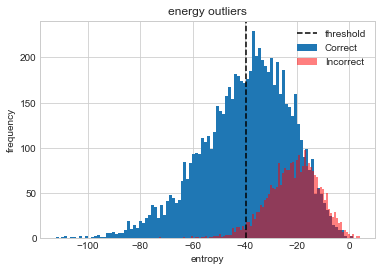

-----------------
rollover enabled, 6540 predictions provided
['exit_1', 'exit_2']
947 inputs accepted 909 Correct


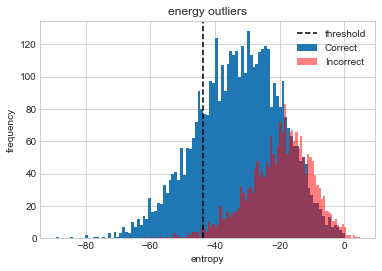

-----------------
rollover enabled, 5593 predictions provided
main_exit
5593 inputs accepted 5246 Correct


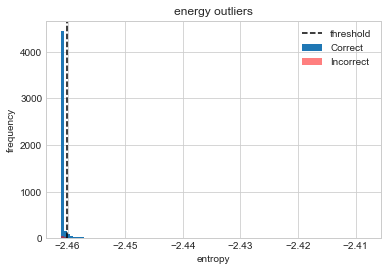

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7266           0.726600 -39.365479      3460              3337        0.346000             0.964451
1     exit_2         6540         0.7803           0.682416 -43.807041       947               909        0.144801             0.959873
2  Main_exit         5593         0.9602           0.937958  -2.460171      5593              5246        1.000000             0.937958


In [20]:
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=True)


In [21]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)


metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7266           0.726600 -43.702904      2735              2679        0.273500             0.979525
1     exit_2         7265         0.7803           0.704198 -54.312119       398               391        0.054783             0.982412
2  Main_exit         6867         0.9602           0.945682  -2.410235      6867              6494        1.000000             0.945682


In [97]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7266           0.726600 -43.702904      2735              2679        0.273500             0.979525
1     exit_2         7265         0.7803           0.704198 -54.312119       398               391        0.054783             0.982412
2  Main_exit         6867         0.9602           0.945682  -2.410235      6867              6494        1.000000             0.945682
metric:  energy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7266           0.726600 -39.365479      3460              3337        0.346000             0.964451
1     exit_2         6540       

### ID/OOD branch performance
<hr>

metric:  energy threshold:  gmean
energy  lr_auc 0.127204800448285 Best Threshold=-52.8938102722168, G-Mean=0.8001359698780575, TPR=0.8533171028606208, FPR=0.2497307646284552


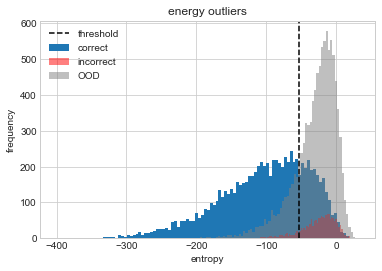

['exit_1']
energy  lr_auc 0.12102239000607297 Best Threshold=-53.94914245605469, G-Mean=0.8052155040848356, TPR=0.8469453376205788, FPR=0.2344582593250444


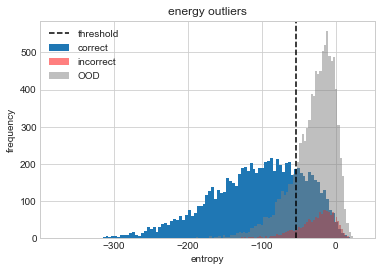

['exit_1', 'exit_2']
energy  lr_auc 0.0725530407098074 Best Threshold=-2.4607272148132324, G-Mean=0.8615849933045198, TPR=0.8826291079812206, FPR=0.1589573763486807


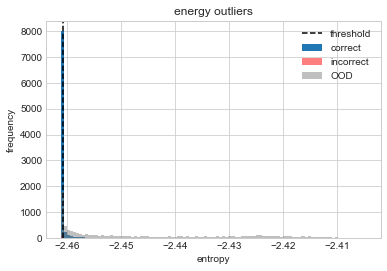

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8357  -52.89381         6512          1941              6270           0.770377             0.741748
1     exit_2       3488        8059         0.8445 -53.949142         1109          1009               968           0.523607             0.457035
2  Main_exit       2379        7050         0.9361         NA         2379          7050              1995           0.252307             0.211581


In [15]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)



In [47]:
# evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=False)
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "gmean",plot=False)

metric:  calibration threshold:  gmean
calibration  lr_auc 0.7346625017071626 Best Threshold=1.0, G-Mean=0.7123912537912335, TPR=0.8710435212660732, FPR=0.41736401673640167
['exit_1', 'exit_2']
calibration  lr_auc 0.7220322072762225 Best Threshold=1.0, G-Mean=0.696826097370901, TPR=0.8869069738634956, FPR=0.45251686559418786
['exit_1', 'exit_2']
calibration  lr_auc 0.8872806875304038 Best Threshold=0.2212609499692917, G-Mean=0.814571975995787, TPR=0.7841089670828604, FPR=0.15378151260504203
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8088       1.0         7843          4549              7045           0.632908             0.568512
1     exit_2       2157        5451         0.8073       1.0         1150          2232               772           0.340035             0.228267
2  Main_exit       1007        3219         0.8810        NA      

## Entropy Branch version
Now we build a branched model with the entropy metric and cross entropy loss for comparision.
<hr>

In [23]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

lambda_callback = lambda_update(1000,0,max_t = 0.01)
# branch_loss = brevisEnergy(lambda_callback)
branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = brevis.BranchModel(name="./models/inception_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["mixed0","mixed1",#"mixed6"
                          ],
                          target_input=False,loop=False,num_outputs=10)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy'])




Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  mixed0
add Branch to branch point  mixed1
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001DC76EB0848>

preset: Other


In [24]:
model.fit(train_ds, epochs = 5, validation_data=validation_ds, transfer=True,callbacks=[lambda_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/5
1407/1407 [==============================] - 356s 245ms/step - loss: 2.1845 - classification_loss: 0.0415 - branch_exit_loss: 1.0931 - branch_exit_1_loss: 1.0498 - classification_accuracy: 0.9855 - branch_exit_accuracy: 0.6214 - branch_exit_1_accuracy: 0.6342 - val_loss: 1.5822 - val_classification_loss: 0.0222 - val_branch_exit_loss: 0.7844 - val_branch_exit_1_loss: 0.7756 - val_classification_accuracy: 0.9926 - val_branch_exit_accuracy: 0.7164 - val_branch_exit_1_accuracy: 0.7246
annealing coef updated to: 0.001
Epoch 2/5
1407/1407 [==============================] - 329s 232ms/step - loss: 1.3876 - classification_loss: 0.0258 - branch_exit_loss: 0.7093 - branch_exit_1_loss: 0.6525 - classification_accuracy: 0.9915 - branch_exit_accuracy: 0.7524 - branch_exit_1_accuracy: 0.7702 - val_loss: 1.3860 - val_classification_loss: 0.0156 - val_branch_exit_loss: 0.6570 - val_branch_exit_1_los

In [25]:
model.evaluate(test_ds)

313/313 [==============================] - 18s 57ms/step - loss: 1.3121 - classification_loss: 0.1717 - branch_exit_loss: 0.5767 - branch_exit_1_loss: 0.5637 - classification_accuracy: 0.9608 - branch_exit_accuracy: 0.8066 - branch_exit_1_accuracy: 0.8175


[1.3121238946914673,
 0.1716654747724533,
 0.5767245292663574,
 0.5637335181236267,
 0.9607999920845032,
 0.8065999746322632,
 0.8174999952316284]

In [26]:
model.save("./models/journal_models/inception_B_conv3_5.hdf5")

## Get the Branch output results
Collect the branch output results for both the ID and OOD test sets then evaluate the results.

In [27]:
output_ID_old= evaluate.getPredictions_Energy(model, test_ds,stopping_point=None)
for i in output_ID_old:
    i['outlier']=0


outputs 3


In [28]:
output_OOD_old = evaluate.getPredictions_Energy(model, test_ds100,stopping_point=None)
for i in output_OOD_old:
    i['correct']=0
    i['outlier']=1

outputs 3


In [39]:
def save_outputs(filename,outputs):
    from openpyxl import Workbook
    wb= Workbook()
    ws=wb.active
    with pd.ExcelWriter('./csv/'+filename+'.xlsx', engine="openpyxl") as writer:
        writer.book=wb
        writer.sheets = dict((ws.title, ws) for ws in wb.worksheets)

        #useful code
        for i, df in enumerate(outputs):
            name = "exit{}".format(i+1)
            df.to_excel(writer, name)
        # df.to_excel(writer, sheet, ...)
        writer.save()
    wb.close()
    
def read_outputs(fileName):
    output_test = list(pd.read_excel('./csv/'+fileName+'.xlsx',['exit1','exit2','exit3']).values())
    # for i in output_test:
        # print(i.head())
    return output_test
filename = 'inception_CE_10'
save_outputs(filename+'_ID',output_ID)
save_outputs(filename+'_OOD',output_OOD)
# save_outputs(filename+'_OOD_SVHN',output_OOD_SVHN)

### T/F in distribution performance
<hr>

In [40]:
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=True)
evaluate.calculateBranching(output_ID_old,threshold="gmean",metrics=["calibration"],main_exit_included=True,plot=True)

NameError: name 'output_ID_old' is not defined

In [99]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["entropy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["entropy"],main_exit_included=True,plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy     Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7266           0.726600  8.462244e-15      2735              2682        0.273500             0.980622
1     exit_2         7265         0.7803           0.704474  4.188502e-21       509               498        0.070062             0.978389
2  Main_exit         6756         0.9602           0.944494  3.310396e+00      6756              6381        1.000000             0.944494
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.7266            0.72660   0.039503      8394              6628        0.839400             0.789612
1     exit_2      

### ID/OOD branch performance
<hr>

In [35]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID_old, output_OOD_old, ["entropy"], "mean",plot=False)

# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  entropy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8066   0.01501         1935            86              1926           0.957447             0.952994
1     exit_2       8065        9914         0.8175  0.003296          606            46               601           0.929448             0.921779
2  Main_exit       7459        9868         0.9608        NA         7459          9868              7075           0.430484             0.408322
metric:  entropy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.8066  0.442672         5488          1523              5299           

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    _output_ID = ID
    _output_OOD = OOD

    _output_ID["outlier"]=0
    _output_OOD["outlier"]=1
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    for i in OOD_rate:
        # print(int(min((len(_output_ID) * i),len(_output_ID))))
        _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
        print("OOD size",len(_OOD))
        _df = pd.concat([_output_ID,_OOD], ignore_index=True)
        y_true = np.int32(_df['outlier'])

    #     print(len(_df))
    #     for metric in metrics:
    #         points.append([])
    #         # print(metric, ":", average_precision_score(y_true, _df[metric]))

    #         Correct = _df.loc[(_df['correct'] == True)]
    #         Incorrect = _df.loc[(_df['correct'] == False)]
    #         fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
    #         gmeans = sqrt(tpr * (1-fpr))
    #         ix = argmax(gmeans)
    #         _threshold = thresholds[ix]
    #         # _threshold = np.array(Correct[metric]).mean()
        plots = []
        for metric in metrics:    
            lr_auc = roc_auc_score(y_true, _df[metric])
            print("lr_auc",lr_auc)
            if metric in lessThanMetrics:
                pos_label = 0
            else:
                pos_label = 1
            fpr, tpr, thresholds = roc_curve(y_true, _df[metric],pos_label=pos_label)
            gmeans = sqrt(tpr * (1-fpr))
            # print(gmeans)
            # locate the index of the largest g-mean
            ix = argmax(gmeans)
            threshold = thresholds[ix]
            print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
            _thresholds.append(threshold)
            # plot the roc curve for the model
            plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
        # if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])      

In [92]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


In [94]:
calc_auc_OOD(output_ID_old, output_OOD_old, ["entropy"], "mean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  mean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.8066  0.442672         5488           156              5299           0.972360             0.938873
1     exit_2       4512         844         0.8175  0.363079         1210           112              1064           0.915280             0.804841
2  Main_exit       3302         732         0.9608        NA         3302           732              3029           0.818542             0.750868
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.8066  0.442672         5488           321              5299           0.944741  

In [96]:
calc_auc_OOD(output_ID, output_OOD, ["energy"], "mean",OOD_rate=[.1,.2,.5,1],plot=False)

# 268,519,1273,2539

metric:  energy threshold:  mean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7266 -39.365479         3460            68              3337           0.980726             0.945862
1     exit_2       6540         932         0.7803 -43.807041          947            27               909           0.972279             0.933265
2  Main_exit       5593         905         0.9602         NA         5593           905              5246           0.860726             0.807325
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.7266 -39.365479         3460           124              3337           0.965

In [ ]:
# 95, 181, 417, 798